## Предварительная обработка признаков

На каждом соревновании нам необходимо предварительно обработать заданный набор данных и создать новые признаки на основе существующих. Это часто требуется, для того, чтобы оставаться на одном уровне с другими участниками соревнований, и иногда тщательная предварительная обработка признаков и разработка качественных признаков могут дать вам преимущество. Таким образом, мы рассмотрим очень полезную тему предварительной обработки основных признаков и генерацию новых признаков. А именно, мы рассмотрим числовые признаки, категориальные признаки, признаки даты и времени и признаки на основе координат.

__Пример:__ рассмотрим простой пример, возьмем знаменитый датасет Титаник, где каждая строка представляет пассажира Титаника, а каждый столбец - описание пассажира. Наша целевая переменная __«Survived»__, это задача бинарной классификации, мы хотим предсказать вероятность, с которой пассажир выживет при катастрофе. В качестве признаков у нас есть возраст, стоимость билета и так далее. В данном наборе данных есть непрерывные признаки и категориальные.

Итак, постараемся понять почему важно понимать и знать, почему разные признаки должны иметь разный тип? Есть 2 причины, а именно сильная связь между предварительной обработкой признаков и методами генерации признаков для каждого семейства моделей.  В большинстве случаев мы можем просто использовать признаки, как есть, обучить любимую модель и ожидать от нее хороших результатов. Однако, у каждого типа признаков есть способы предварительной обработки для улучшения качества модели.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats.mstats import winsorize

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

In [11]:
data = pd.read_csv("data/titanic-machine-learning-from-disaster/train-2.csv")
data.head(n=2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


__Например__, предположим, что целевая переменная имеет нелинейную зависимость от признака `Age`. Поскольку это линейная модель, то она может восстановить только линейные зависимости, а если зависимость нелинейная - то у нас есть проблемы. Для улучшения качества линейной модели, мы хотели бы каким-то образом предварительно обработать признак `Age`. 

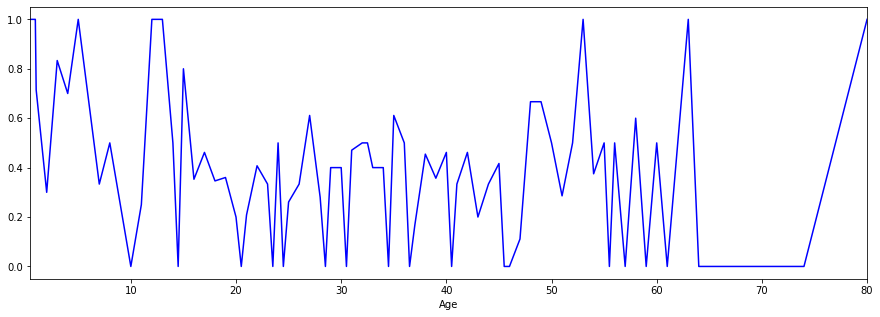

In [12]:
fig = plt.figure(figsize=(15, 5))
data.groupby(["Age"])["Survived"].mean().plot(color="blue")

С другой стороны, модель случайного леса вообще не требует преобразования признака `Age`. Случайный лес может легко сделать сплиты в деревьях так, чтобы одинаковые категории возраста были сосредоточены в одном листе. Итак, это был пример предварительной обработки признаков с учетом требований семейства моделей. __Вторая причина__, по которой мы должны знать о типе признаков - это упростить процесс создания новых признаков. Как именно нам это может помочь? Предположим, что мы хотим спрогнозировать некоторую целевую переменную, которая имеет временную зависимость, например: продажа определенного товара в зависимости от номера недели года. Давайте предположим, что у нас есть очевидный линейный тренд по данным, и мы хотим явно учесть эту информацию в модели. 

Text(0.5, 0, 'time')

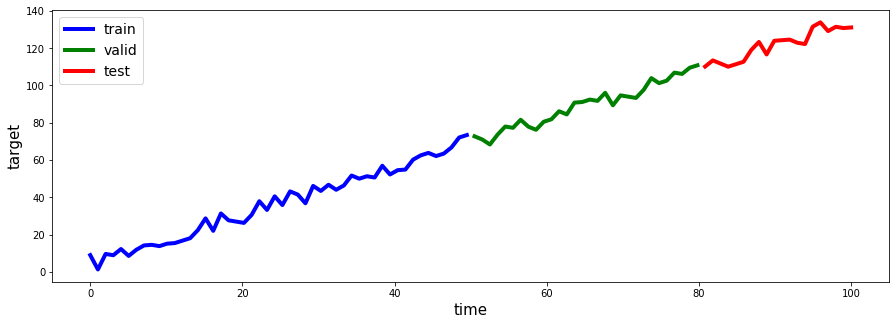

In [13]:
x = np.linspace(0, 100, 100)
y = 1.3*x + np.random.randint(0, 10, size=x.shape[0])

plt.figure(figsize=(15, 5))
plt.plot(x[:50], y[:50], linewidth=4, color="blue", label="train")
plt.plot(x[50:80], y[50:80], linewidth=4, color="green", label="valid")
plt.plot(x[80:], y[80:], linewidth=4, color="red", label="test")
plt.legend(loc="best", fontsize=14)
plt.ylabel("target", size=15)
plt.xlabel("time", size=15)

Один из способов помочь модели учесть такой тренд - добавить признак, указывающую номер недели. С помощью этого признака, __линейная модель может успешно найти зависимость__ между номером недели и целевой переменной. 

С другой стороны, если мы будем использовать модели на основе решающих деревьев, то они будут использовать ждя прогнозов, среднее значение целевой переменной из обучающей выборки, в каждом листе. Мы не обудем обучать модель на данных 80-100 недель, и такая модель не сможет восстановить точную зависимость целевой переменной, поскольку модель не умеют экстраполировать. 

Таким образом, этот пример показывает нам, что наш подход к созданию новых признаков должен основываться на понимании принципа работы модели, которую мы выбрали. Таким образом, предварительная обработка признаков - это необходимый инструмент, который необходимо использовать для адаптации данных к модели. Во-вторых, создание новых признаков - очень мощный инструмент, который очень сильно помогает повысить качество работы модели в соревновании.

## Числовые признаки

Рассмотрим как выбор модели влияет на предварительную обработку признаков. Первое, на что мы обратим внимание, это то, что существует класс моделей, которые зависят и не зависят от масштаба признаков. Мы можем разделить все модели на 2 больших класса: модели, построенные на деревьях решений и другие модели. Например, классификатор на основе деревьев решений пытается найти оптимальный полезный сплит для каждого признака. Таким образом мы можем умножить признак на константу, переобучить модель, и она не поменяет своего поведения и прогнозов, образованных в листьях.

In [14]:
features = [
    "Pclass", "Age", "SibSp", "Parch", "Fare"
]
target = "Survived"

estimator = RandomForestClassifier(
    random_state=27, n_jobs=4
)

In [15]:
cv = cross_val_score(
    estimator=estimator,
    X=data[features].fillna(-9999),
    y=data[target],
    scoring="roc_auc",
    cv=3,
)

print(f"CV-result: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

CV-result: 0.7225 +/- 0.02


In [16]:
data_transformed = data[features].copy()
data_transformed["Age"] = 100 * data_transformed["Age"]

cv = cross_val_score(
    estimator=estimator,
    X=data_transformed[features].fillna(-9999),
    y=data[target],
    scoring="roc_auc",
    cv=3,
)

print(f"CV-result: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

CV-result: 0.7225 +/- 0.02


С другой стороны, есть модели, которые зависят от такого рода преобразований. Алгоритм на основе k ближайших соседей, линейные модели и нейронные сети относятся к такому классу моделей. Почему линейные модели нуждаются в масштабировании данных? С одной стороны, мы хотим, чтобы регуляризация применялась к коэффициентам линейных моделей для признаков в равной доле, и на самом деле, влияние регуляризации прямо пропорционально масштабу признака. С другой стороны, градиетные методы оптимизации будут плохо работать без масштабирования. __Важно понимать__, что разные способы масштабирования данных приводят к разным моделям и разному качеству моделей. Получается, что вид масштабирования признаков - это еще один гиперпараметр, который нужно оптимизировать. Самый простой способ отмасшатабировать данные - это использовать __стандартизацию__ (все признаки имеют нулевое среднее значение и единичную дисперсию) или использовать __масштабирование__ (все признаки распределены на отрезке [0, 1]). Проиллюстрируем использование обоих трансформеров на наших данных:

In [17]:
estimator = LogisticRegression(random_state=27)

pipeline_std = Pipeline(
    steps=[("scaling", StandardScaler()), ("estimator", estimator)]
)
pipeline_mm = Pipeline(
    steps=[("scaling", MinMaxScaler()), ("estimator", estimator)]
)

In [18]:
cv_std = cross_val_score(
    estimator=pipeline_std,
    X=data[features].fillna(0),
    y=data[target],
    scoring="roc_auc",
    cv=3,
)

print(f"CV-result: {round(np.mean(cv_std), 4)} +/- {round(np.std(cv_std), 3)}")

cv_mm = cross_val_score(
    estimator=pipeline_mm,
    X=data[features].fillna(0),
    y=data[target],
    scoring="roc_auc",
    cv=3,
)

print(f"CV-result: {round(np.mean(cv_mm), 4)} +/- {round(np.std(cv_mm), 3)}")

CV-result: 0.7152 +/- 0.056
CV-result: 0.7145 +/- 0.059


После преобразований `MinMaxScaling` или `StandardScaling` влияние признаков на модели, не основанные на деревьях, будет примерно одинаковым. Более того, если вы хотите использовать `KNNClassifier`, мы можем пойти на шаг вперед и вспомнить, что чем больше значение признака, тем важнее он будет для `KNNClassifier`. Итак, мы можем оптимизировать этап масштабирования для улучшения признаков, которые кажутся нам наиболее важными, и посмотреть, поможет ли это. Когда мы работаем с линейными моделями, есть еще один важный момент, который влияет на результаты обучения модели.

Другой важный аспект. Представим, что у нас есть модель, обученная на данных с целевыми переменной от 0 до 1000.

In [20]:
def linear_model_fit_transform(X: np.array, y: np.array) -> np.array:
    """
    Обучение и применение линейной модели к набору данных.

    Parameters
    ----------
    X: numpy.array, shape = [n_samples, n_features]
        Матрица признаков.

    y: numpy.array, shape = [n_samples, ]
        Вектор целевой переменной.

    Returns
    -------
    y_pred: numpy.array, shape = [n_samples, ]
        Вектор прогнозов.

    """
    model = LinearRegression()
    model.fit(X.reshape(X.shape[0], -1), y)
    y_pred = model.coef_*X + model.intercept_

    return y_pred

In [21]:
x = np.arange(0, 1000, 2)
x = x + np.random.randint(0, 100, x.shape[0])
y = 3*x + 200*np.random.randn(x.shape[0])

y_pred = linear_model_fit_transform(x, y)

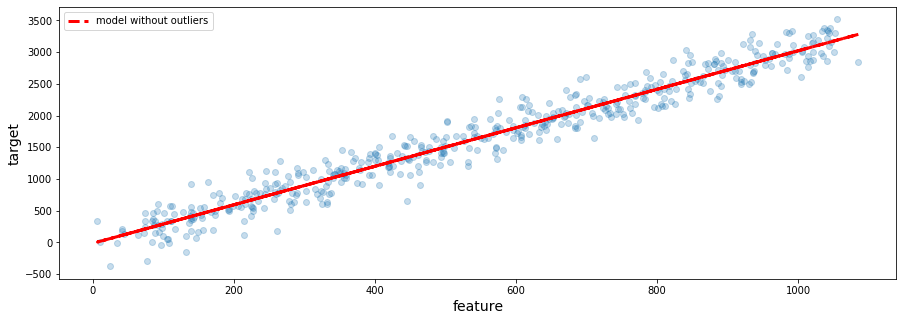

In [22]:
fig = plt.figure(figsize=(15, 5))
plt.scatter(x, y, alpha=0.25)
plt.plot(x, y_pred, color="red", linestyle="--", linewidth=3, label="model without outliers")
plt.xlabel("feature", size=14)
plt.ylabel("target", size=14)
plt.legend(loc="best")

Но, что произойдет, если мы добавим в выборку один пример со значением признака 100000?
Если мы переобучим модель, она будет предсказывать аномально высокие значения. Очевидно, что надо как-то это исправить. Чтобы защитить линейные модели от выбросов, мы можем __обрезать значения признаков__ между двумя выбранными значениями нижней и верхней границы. Мы можем выбрать их как некоторые процентили этой функции. Например, __1-й__ и __99-й__ процентили. Эта процедура называется __винсоризацией__.

In [23]:
x_outliers = x.copy()
x_outliers[0] = 10000

y_outliers_pred = linear_model_fit_transform(x_outliers, y)

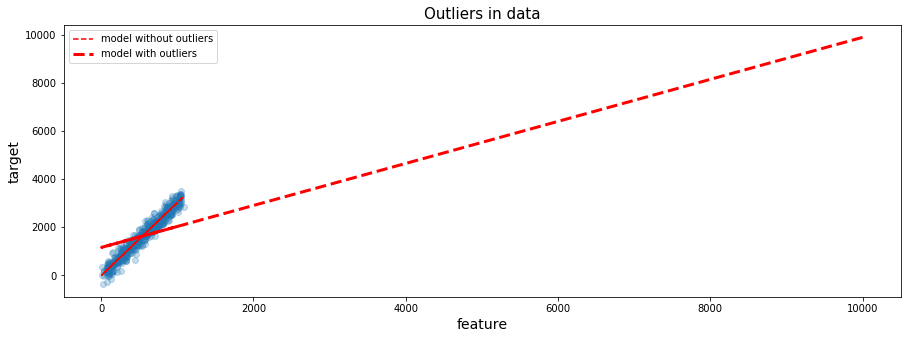

In [24]:
fig = plt.figure(figsize=(15, 5))
plt.scatter(x, y, alpha=0.25)
plt.title("Outliers in data", size=15)
plt.plot(x, y_pred, color="red", linestyle="--", label="model without outliers")
plt.plot(x_outliers, y_outliers_pred, color="red", linestyle="--", linewidth=3, label="model with outliers")
plt.xlabel("feature", size=14)
plt.ylabel("target", size=14)
plt.legend(loc="best")

Отсечем диапазон значений признака, для этого вычислим значения нижней и верхней границы как перцентили уровня 1% и 99%. После того, как мы отсечем значения признака, распределение признака будет выглядит нормально, и мы надеемся, что теперь этот признак будет полезным для нашей модели.

In [25]:
LEFT_BOUND, RIGHT_BOUND = np.percentile(x_outliers, q=1), np.percentile(x_outliers, q=99)
x_winsorized = np.clip(x_outliers, LEFT_BOUND, RIGHT_BOUND)
assert x_winsorized.shape[0] == x_outliers.shape[0]

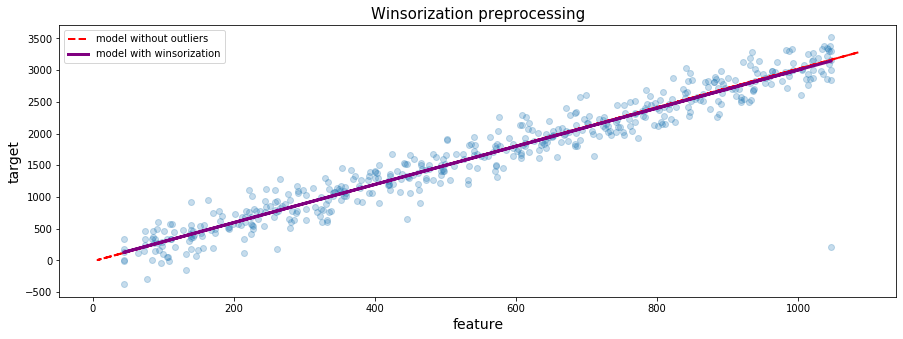

In [26]:
y_winsorized_pred = linear_model_fit_transform(x_winsorized, y)

fig = plt.figure(figsize=(15, 5))
plt.scatter(x_winsorized, y, alpha=0.25)
plt.title("Winsorization preprocessing", size=15)
plt.plot(x, y_pred, color="red", linewidth=2, linestyle="--", label="model without outliers")
plt.plot(x_winsorized, y_winsorized_pred, linewidth=3, color="purple", label="model with winsorization")
plt.xlabel("feature", size=14)
plt.ylabel("target", size=14)
plt.legend(loc="best")

Еще одна эффективная предварительная обработка числовых признаков - это преобразование рангов. По сути, он устанавливает равные пробелы между отсортированными значениями. Это преобразование может быть лучшим вариантом, чем `MinMaxScaler`, если у нас есть выбросы, потому что преобразование ранга переместит выбросы ближе к другим объектам. Линейные модели, `KNN` и нейронные сети могут выиграть от такого преобразования, если у нас нет времени обрабатывать выбросы вручную. 

In [27]:
x_rank = rankdata(x)
x_outliers_rank = rankdata(x_outliers)

y_pred_rank = linear_model_fit_transform(x_rank, y)
y_outliers_pred_rank = linear_model_fit_transform(x_outliers_rank, y)

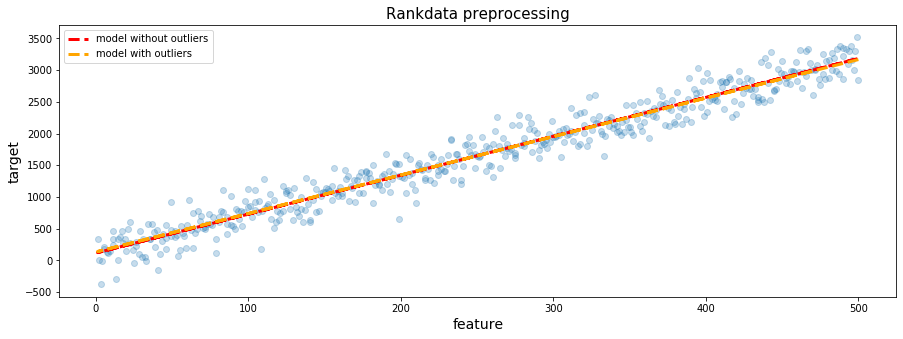

In [28]:
fig = plt.figure(figsize=(15, 5))
plt.scatter(x_rank, y, alpha=0.25)
plt.title("Rankdata preprocessing", size=15)
plt.plot(x_rank, y_pred_rank, color="red", linestyle="--", linewidth=3, label="model without outliers")
plt.plot(x_outliers_rank, y_outliers_pred_rank, color="orange", linestyle="--", linewidth=3, label="model with outliers")
plt.xlabel("feature", size=14)
plt.ylabel("target", size=14)
plt.legend(loc="best")

__ВАЖНО!__ При использовании преобразовании на основе рангов, нужно внимательно применить это преобразование к тестовым данным, Самое простое, объединить обучающую и тестовую выборку перед применение рангового преобразования.

Для линейных моделей, нейронных сетей и `KNN` очень важна чистота данных. Теперь перейдем к генерации признаков. Создание новыъ признаков - это процесс создания признаков с использованием знаний о данных, задаче и алгоритмах. 

## Категориальные признаки

Давайте перейдем к категориальным признакам, это: `Sex`, `Cabin` и `Embarked`. Это обычные категориальные признаки, но есть еще один специаильный признак - `Pclass`. `Pclass` обозначает класс каюты и имеет три уникальных значения: один, два и три. Это __порядковый__ или, другими словами, __порядковый категориальный__ признак. Это означает, что значения данного признака упорядочены определнным образом. __Например__, если билет в каюту первого класса будет дороже чем билета во каюту второго класса. При этом важно понимать разницу между числовм и порядковым признаком. Если бы `Pclass` был числовым признаком, то мы могли бы сказать, что разница между первым и вторым классом равна разнице между вторым и третьим классом, но это не так. Мы не знаем разница между какими классами больше. Другой пример порядкового номера - тип водительских прав. Это либо A, B, C, либо D.

__Самый простой способ__ закодировать категориальный признак - сопоставить его уникальные значения с разными числами, такой подход называется `LabelEncoder`. Этот метод работает очень хорошо, потому что модели на основе деревьев умеют разделять такие признаки и могут самостоятельно извлекать большую часть полезных знаний из данного значения категории. С другой стороны, другие модели плохо будут обрабатывать такой признак.

__Второй способ__ кодирования категориальных переменных - частоты, вместо метки значения категории присваиваем частоту, с которой это значение встречается. Так мы сохраним информацию о частоте каждого значения, что будет особенно полезно, если эта частота коррелирует с целевой переменной. Такой подход позволит сохранить некоторую информацию о распределении значений и может помочь как в линейных, так и в моделях, основанных на основе деревьев. Для линейных моделей такая предобработка может быть полезный, если частота значений коррелирует с целевым значением. А деревья могут найти меньшее количеством сплитов по той же причине. По поводу частотного кодирования есть еще один важный момент. Если имеется несколько категорий с одинаковой частотой, они не будут различимы в таком признаке.

In [38]:
freq_encoder = data["Embarked"].value_counts(normalize=True)
data["Embarked_freq_enc"] = data["Embarked"].map(freq_encoder)
data[["Embarked", "Embarked_freq_enc"]].head(2)

,Embarked,Embarked_freq_enc
0,S,0.724409
1,C,0.188976


__Третий способ__, возможно, __самый известный__ способ обработки категориальных переменных - это `OneHotEncoding`. Идея заключается в том, чтобы провести автоматическое шкалирование переменных, где 1 - будет соответствать тому значению категории, которое встретилось, а 0 - для всех остальных значений категориального признака, которые встретились в датасете. С помощью `OneHotEncoding` шкалирование происходит автоматически, таким образом матрица признаков может сильно разрастись, если уникальных значений кагориатнлього признака много. При этом, с `OneHotEncoding` __нужно быть очень аккуратным__: если у вас много категориальных признаков и несколько метрических, то деревья решений могут испытывать сложности с тем, что использовать метрические признаки эффективно.

In [39]:
pd.get_dummies(data["Embarked"]).head()

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


## datetime - признаки

* периодичность - номер дня в недели, номер месяца, номер недели и т.д.
* время, прошедшее с определенного момента - количество дней с 1 января 1970, количество дней с нового года, количество дней с момента последней транзакции и т.д.
* разница между датами

In [41]:
data = pd.read_csv("data/sberbank-russian-housing-market/train.csv", parse_dates=['timestamp'])
data.head(n=2)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000


In [42]:
start_date = data["timestamp"].min()

data["yearmonth"] = data["timestamp"].dt.year*100 + data["timestamp"].dt.month
data["yearweek"] = data["timestamp"].dt.year*100 + data["timestamp"].dt.weekofyear
data["year"] = data["timestamp"].dt.year

data["month_of_year"] = data["timestamp"].dt.month
data["week_of_year"] = data["timestamp"].dt.weekofyear
data["day_of_week"] = data["timestamp"].dt.weekday
data["diff_date"] = data["timestamp"].apply(lambda x: (x - start_date).days)

data.head(n=2)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,sport_count_5000,market_count_5000,price_doc,yearmonth,yearweek,year,month_of_year,week_of_year,day_of_week,diff_date
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,52,4,5850000,201108,201133,2011,8,33,5,0
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,66,14,6000000,201108,201134,2011,8,34,1,3


(array([2.6955e+04, 3.1030e+03, 2.7700e+02, 7.9000e+01, 3.2000e+01,
        1.4000e+01, 6.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.00000000e+05, 1.12011112e+07, 2.23022224e+07, 3.34033336e+07,
        4.45044448e+07, 5.56055560e+07, 6.67066672e+07, 7.78077784e+07,
        8.89088896e+07, 1.00010001e+08, 1.11111112e+08]),
 <a list of 10 Patch objects>)

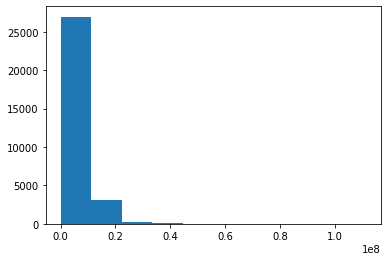

In [43]:
plt.hist(data["price_doc"])

(array([3.0000e+00, 9.0000e+00, 2.2000e+01, 1.1850e+03, 2.3510e+03,
        1.4101e+04, 1.0900e+04, 1.6740e+03, 2.0000e+02, 2.6000e+01]),
 array([11.51392497, 12.21513669, 12.91634841, 13.61756013, 14.31877185,
        15.01998357, 15.72119529, 16.42240701, 17.12361873, 17.82483045,
        18.52604217]),
 <a list of 10 Patch objects>)

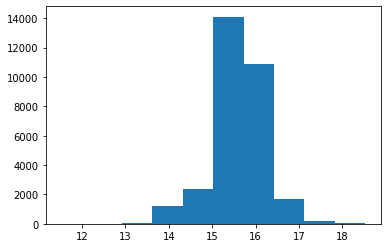

In [45]:
plt.hist(np.log(data["price_doc"]+100))

## Дополнительные материалы

* Box-Cox преобразование
* WOE преобразование